In [1]:
## Add path to sys
import sys
sys.path.append('../../')
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from preprocessing import data_processing
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
train_dataset = 'D:/Projects/tumai_braintumor_classification/dataset/train/'
test_dataset = 'D:/Projects/tumai_braintumor_classification/dataset/test/'
IMG_SIZE = (224,224)

X_train, y_train, labels = data_processing.load_data_tonumpy(train_dataset, IMG_SIZE)
X_test, y_test, _ = data_processing.load_data_tonumpy(test_dataset, IMG_SIZE)


100%|██████████| 2/2 [00:00<00:00,  3.03it/s]


202 images loaded from D:/Projects/tumai_braintumor_classification/dataset/train/ directory.


100%|██████████| 2/2 [00:00<00:00, 10.36it/s]

51 images loaded from D:/Projects/tumai_braintumor_classification/dataset/test/ directory.


## Image cropping example
https://www.kaggle.com/code/fadhlalhafizh/brain-tumor-vgg16-resnet50-inceptionv3

In [3]:
# apply this for each set
X_train_crop = data_processing.crop_imgs(set_name=X_train)
X_test_crop = data_processing.crop_imgs(set_name=X_test)

### Trying TL Models

In [10]:
from keras.applications.resnet import ResNet50, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from matplotlib import pyplot 
from numpy import expand_dims

In [11]:
def preprocess_for_resnet(set_name, img_size):
    """
    Resize and apply VGG-15 preprocessing
    """
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        # set_new.append(preprocess_input(img))
        set_new.append(img/255)
    return np.array(set_new)

In [12]:
X_train_prep = preprocess_for_resnet(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_for_resnet(set_name=X_test_crop, img_size=IMG_SIZE)

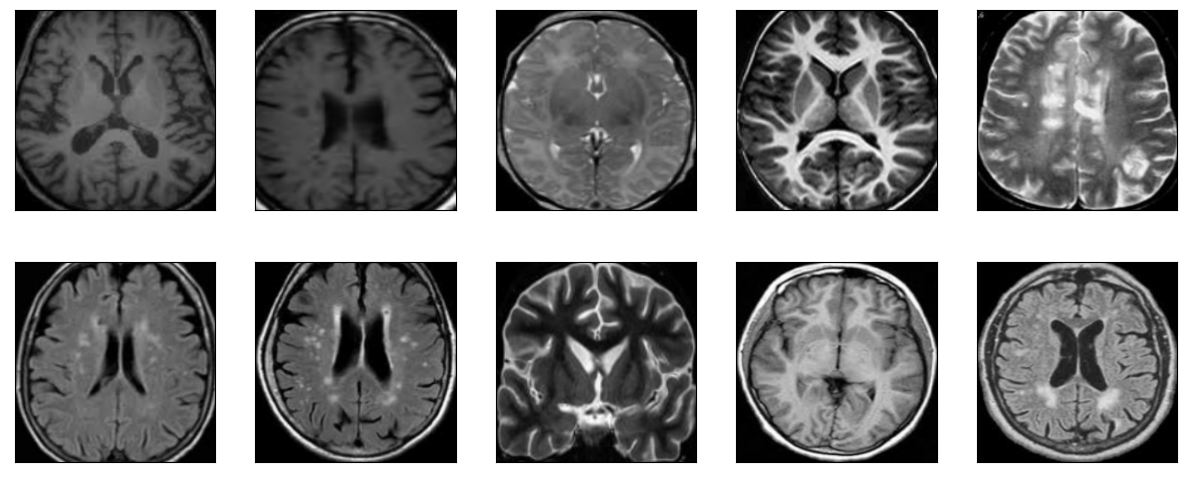

In [13]:
## Plot 10 images from X_train_crop
plt.figure(figsize=(15,6))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(X_train_prep[i])
    plt.xticks([])
    plt.yticks([])
plt.show()

In [14]:
## Make a VGG16 model and freeze the layers and add a head 
net = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
net.trainable = False
model = Sequential()
model.add(net)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()


## Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 512)               51380736  
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 74,968,961
Trainable params: 51,381,249
Non-trainable params: 23,587,712
_________________________________________________________________


In [18]:
## Early stopping
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    verbose=1,
    restore_best_weights=True
)


model.fit(
    X_train_prep,
    y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test_prep, y_test),
    callbacks=[early_stopping]
)

Epoch 1/50
7/7 [==============================] - 18s 3s/step - loss: 0.4950 - accuracy: 0.7723 - val_loss: 0.5216 - val_accuracy: 0.6667
Epoch 2/50
7/7 [==============================] - 17s 2s/step - loss: 0.4947 - accuracy: 0.7871 - val_loss: 0.5304 - val_accuracy: 0.6667
Epoch 3/50
7/7 [==============================] - 18s 3s/step - loss: 0.5111 - accuracy: 0.7327 - val_loss: 0.5305 - val_accuracy: 0.6863
Epoch 4/50
7/7 [==============================] - 17s 3s/step - loss: 0.4847 - accuracy: 0.7673 - val_loss: 0.5222 - val_accuracy: 0.7255
Epoch 4: early stopping


In [17]:
model.evaluate(X_test_prep, y_test)

2/2 [==============================] - 3s 1s/step - loss: 0.5273 - accuracy: 0.7451


[0.5273255705833435, 0.7450980544090271]

## Checking the model

In [19]:
from sklearn.metrics import f1_score, confusion_matrix

y_pred = model.predict(X_test_prep)
y_pred = np.where(y_pred > 0.5, 1, 0)

f1_score(y_test, y_pred)
confusion_matrix(y_test, y_pred)

2/2 [==============================] - 4s 1s/step


array([[11,  9],
       [ 8, 23]], dtype=int64)

In [18]:
## Get all X_test and y_test with wrong prediction

X_test_wrong = X_test_prep[y_test != y_pred.reshape(-1)]
y_test_wrong = y_test[y_test != y_pred.reshape(-1)]

X_test_right = X_test_prep[y_test == y_pred.reshape(-1)]
y_test_right = y_test[y_test == y_pred.reshape(-1)]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


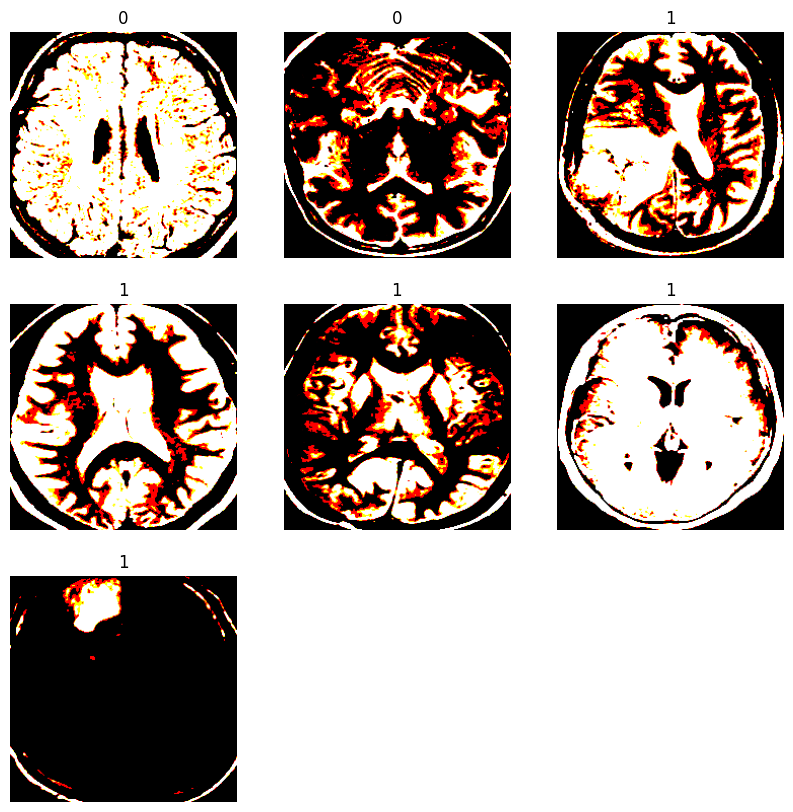

In [19]:
## Plot all wrong prediction

plt.figure(figsize=(10, 10))
for i in range(len(X_test_wrong)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(X_test_wrong[i], cmap='gray')
    plt.title(str(y_test_wrong[i]))
    plt.axis("off")

plt.show()

In [20]:
import shap
explainer = shap.DeepExplainer(model, data=X_test_prep)

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


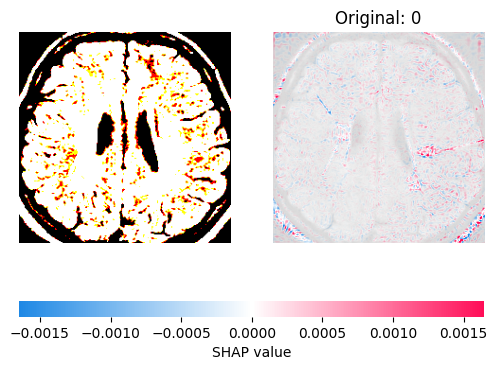

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


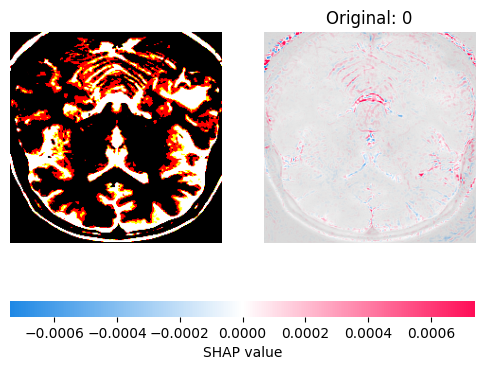

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


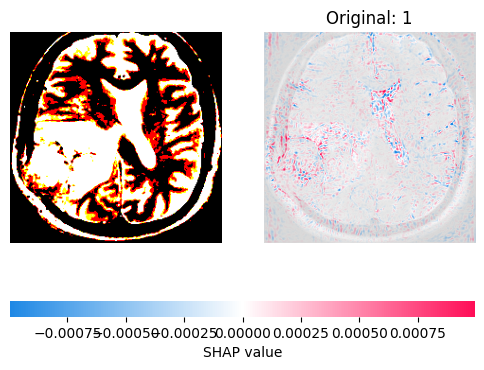

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


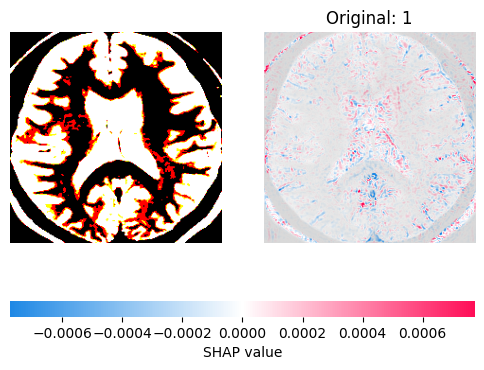

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


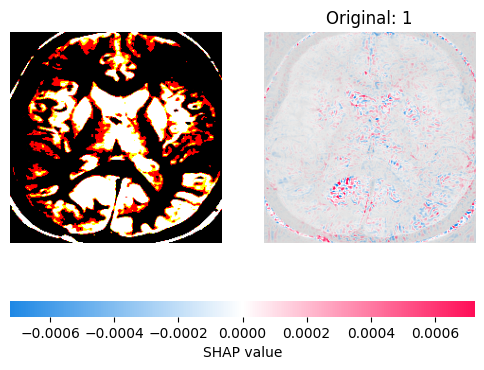

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


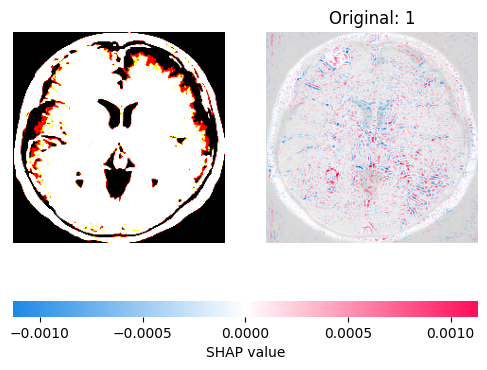

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


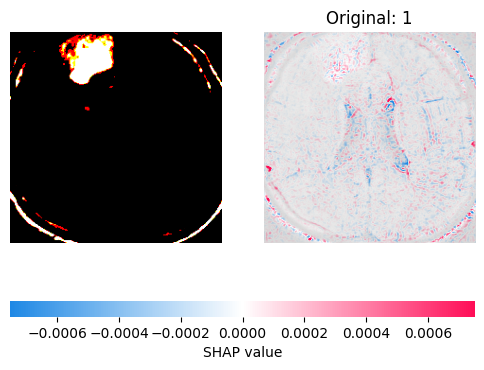

In [21]:
# Create an explainer object
for i in range(len(X_test_wrong)):
    # Get a sample the wrong prediction
    sample = X_test_wrong[i].reshape(1, 224, 224, 3)
    # Get the shap values
    shap_values = explainer.shap_values(sample)
    # Plot the shap values
    ## Add the original and probability of the wrong prediction
    shap.image_plot(shap_values, sample, show=False)
    plt.title('Original: ' + str(y_test_wrong[i]))
    plt.show()

In [22]:
import shap
# Create an explainer object
for i in [0,5,-4,-5,-7]:
    # Get a sample the wrong prediction
    sample = X_test_right[i].reshape(1, 224, 224, 3)
    # Get the shap values
    shap_values = explainer.shap_values(sample)
    # Plot the shap values
    ## Add the original and probability of the wrong prediction
    shap.image_plot(shap_values, sample, show=False)
    plt.title('Original: ' + str(y_test_right[i]))
    plt.show()
